In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from patsy import dmatrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 6. In this exercise, you will further analyze the Wage data set considered throughout this chapter.

wage = pd.read_csv('/home/abhishek/Desktop/ISLR-Applied-Exercises-in-Python/data/Wage.csv')
wage.head()
print(wage.shape)


(3000, 12)


In [3]:
wage = wage.iloc[:,1:] # removing irrelevant column
print(wage.shape)
wage.head()

(3000, 11)


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
# (a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal 
# degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis 
# testing using ANOVA? Make a plot of the resulting polynomial fit to the data.


# a function which performs the polynomial regression, fits and finds a cross validation error for a model with degree 
# from 1 to power
def poly_regression_cv(X, y, power):
    scores_dict = {}
    
    for n in range(1, power+1):
        poly = PolynomialFeatures(n, include_bias=False)
        X_transformed = poly.fit_transform(X.to_frame())
        lin_reg = LinearRegression()
        scores_dict[n] = (-np.mean(cross_val_score(lin_reg, X_transformed, y, scoring = 'neg_mean_squared_error', cv=5)))
    return scores_dict

In [5]:
X = wage['age']
y = wage['wage']

scores_dict = poly_regression_cv(X, y, 15)

Text(0.5, 1.0, 'Polynomial regression using CV')

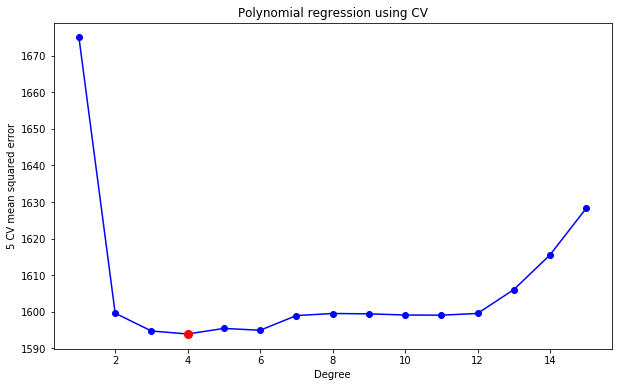

In [6]:
plt.figure(figsize = (10, 6))
plt.plot(np.arange(1, 16), list(scores_dict.values()), marker = 'o', color = 'b')
plt.plot(np.argmin(list(scores_dict.values()))+1, np.min(list(scores_dict.values())), marker = 'o', markersize = 8, color = 'red' )
plt.xlabel('Degree')
plt.ylabel('5 CV mean squared error')
plt.title('Polynomial regression using CV')

In [7]:
# the degree for which the error is minimum is 4.

In [11]:
poly = PolynomialFeatures(5)
X = poly.fit_transform(wage['age'].to_frame())
y = wage['wage']

X_df = pd.DataFrame(X)
X_df.columns = ['Constant'] + ['X_' + str(i) for i in range(1,6)]
X_df.head()

,Constant,X_1,X_2,X_3,X_4,X_5
0,1.0,18.0,324.0,5832.0,104976.0,1889568.0
1,1.0,24.0,576.0,13824.0,331776.0,7962624.0
2,1.0,45.0,2025.0,91125.0,4100625.0,184528125.0
3,1.0,43.0,1849.0,79507.0,3418801.0,147008443.0
4,1.0,50.0,2500.0,125000.0,6250000.0,312500000.0


In [13]:
fit_1 = sm.OLS(y, X_df.iloc[:,:2]).fit() # degree 1
fit_2 = sm.OLS(y, X_df.iloc[:,:3]).fit() # degree 2
fit_3 = sm.OLS(y, X_df.iloc[:,:4]).fit() # degree 3
fit_4 = sm.OLS(y, X_df.iloc[:,:5]).fit() # degree 4
fit_5 = sm.OLS(y, X_df.iloc[:,:6]).fit() # degree 5

table = sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5)
print(table)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


In [14]:
# Annova model chooses degree 3 as the best. 

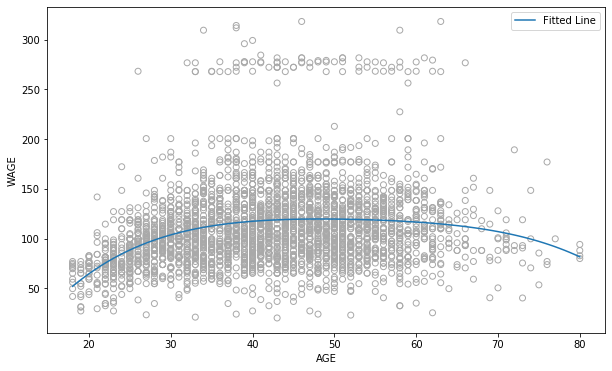

In [21]:
# we would use degree 4 that we got from CV

poly = PolynomialFeatures(4)
X = poly.fit_transform(wage['age'].to_frame())
y = wage['wage']

model = LinearRegression().fit(X, y)

test_ages = np.linspace(wage['age'].min(), wage['age'].max(), 100)
# test_ages
X_test = poly.transform(test_ages.reshape(-1, 1))
pred = model.predict(X_test)

pred = model.predict(X_test)

plt.figure(figsize = (10, 6))
plt.scatter(wage['age'], wage['wage'], facecolors = 'none', edgecolors = 'darkgray')
plt.plot(test_ages, pred, label = 'Fitted Line')
plt.xlabel('AGE')
plt.ylabel('WAGE')
plt.legend()

In [24]:
# (b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number 
# of cuts. Make a plot of the fit obtained

def step_functions_cv(X, y, total_steps):
    scores_dict = {}
    
    for cut in range(2, total_steps):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
        X_cut_train = pd.cut(X_train, cut)
        X_dummies_train = pd.get_dummies(X_cut_train)
        
        X_cut_test = pd.cut(X_test, cut)
        X_dummies_test = pd.get_dummies(X_cut_test)
        
        model = sm.OLS(y_train, X_dummies_train).fit()
        preds = model.predict(X_dummies_test)
        scores_dict[cut] = mean_squared_error(y_test, preds)
    return scores_dict

In [25]:
scores_dict_steps = step_functions_cv(wage['age'], wage['wage'], 16)

Text(0, 0.5, 'Validation Error')

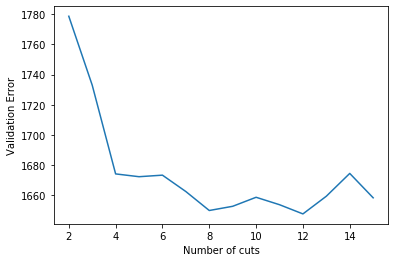

In [26]:
plt.plot(list(scores_dict_steps.keys()), list(scores_dict_steps.values()))
plt.xlabel('Number of cuts')
plt.ylabel('Validation Error')

In [27]:
# we can see from the above graph that the best performance is when cuts = 8

In [28]:
# the selected step function

X_cut = pd.cut(wage['age'], 8)
X_dummies = pd.get_dummies(X_cut)

model = sm.OLS(wage['wage'], X_dummies).fit()
preds = model.predict(X_dummies)


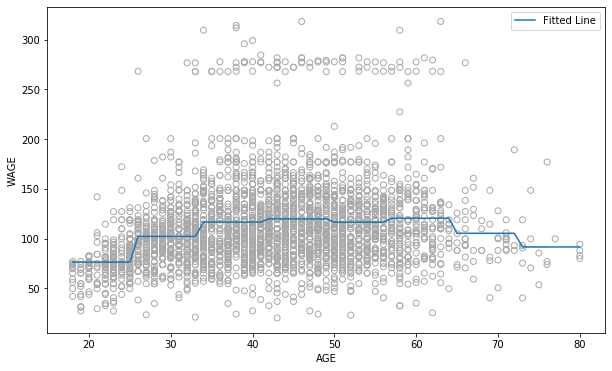

In [29]:
plt.figure(figsize = (10,6))
plt.scatter(wage['age'],wage['wage'],facecolors='none', edgecolors='darkgray')
sns.lineplot(wage['age'],preds,label = 'Fitted Line')
plt.xlabel('AGE')
plt.ylabel('WAGE')
plt.legend()

In [30]:
# 7. The Wage data set contains a number of other features not explored in this chapter, such as marital 
# status (maritl), job class (jobclass), and others. Explore the relationships between some of these other 
# predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. 
# Create plots of the results obtained, and write a summary of your findings.


wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [31]:
wage.dtypes

year            int64
age             int64
maritl         object
race           object
education      object
region         object
jobclass       object
health         object
health_ins     object
logwage       float64
wage          float64
dtype: object

In [32]:
qual_variables = [col for col in wage.columns if wage[col].dtypes == 'O']

for col in qual_variables:
    print(col, wage[col].unique())

maritl ['1. Never Married' '2. Married' '4. Divorced' '3. Widowed' '5. Separated']
race ['1. White' '3. Asian' '4. Other' '2. Black']
education ['1. < HS Grad' '4. College Grad' '3. Some College' '2. HS Grad'
 '5. Advanced Degree']
region ['2. Middle Atlantic']
jobclass ['1. Industrial' '2. Information']
health ['1. <=Good' '2. >=Very Good']
health_ins ['2. No' '1. Yes']


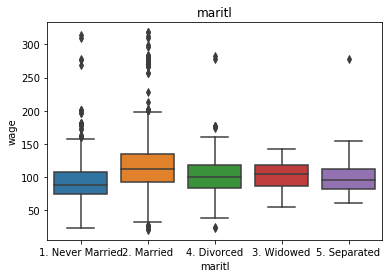

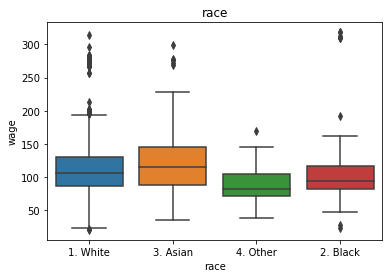

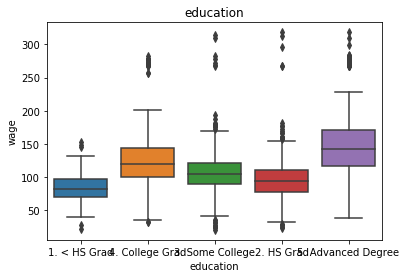

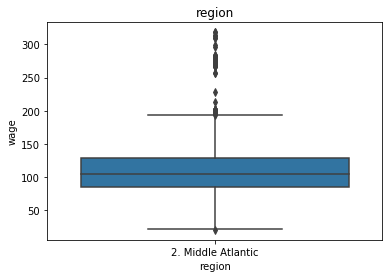

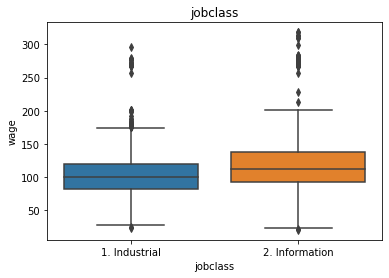

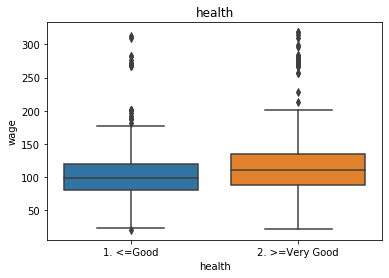

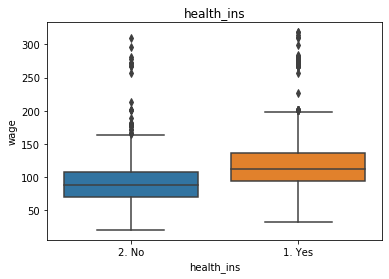

In [34]:
for col in qual_variables:
    if not col == 'wage':
        sns.boxplot(x = col, y = 'wage', data = wage)
        plt.title(col)
        plt.show()

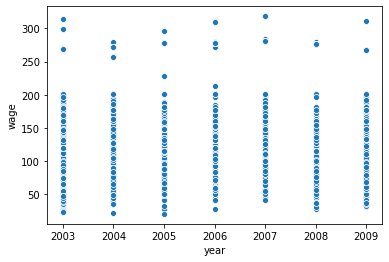

In [35]:
sns.scatterplot(x = 'year', y = 'wage', data = wage)

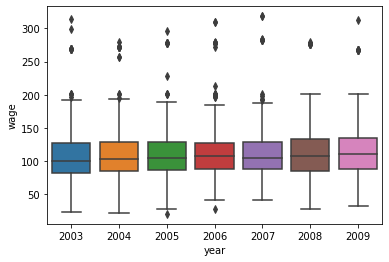

In [36]:
sns.boxplot(x = 'year',y = 'wage',data = wage)

In [37]:
# not much information with year

In [39]:
# fit a GAM where age has a degree 4 relationship with the model

X_transformed = dmatrix('cr(age, df=5, constraints = "center") + education + race + jobclass + health_ins', 
                       data = {'age':wage['age'],'education':wage['education'],'race':wage['race'],
                              'jobclass':wage['jobclass'],'health_ins':wage['health_ins']},return_type = 'dataframe')

model = sm.OLS(wage['wage'], X_transformed).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     102.5
Date:                Tue, 17 Nov 2020   Prob (F-statistic):          7.16e-242
Time:                        11:16:03   Log-Likelihood:                -14861.
No. Observations:                3000   AIC:                         2.975e+04
Df Residuals:                    2985   BIC:                         2.984e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [3]:
# 8. Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence 
# for non-linear relationships in this data set? Create some informative plots to justify your answer


auto = pd.read_csv('/home/abhishek/Desktop/ISLR-Applied-Exercises-in-Python/data/Auto.csv')
print(auto.shape)
auto.head()

(397, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [5]:
auto['horsepower'] = auto['horsepower'].replace('?', np.nan)
auto.dropna(inplace = True)
auto['horsepower'] = auto['horsepower'].astype(np.int32)

In [6]:
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int32
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

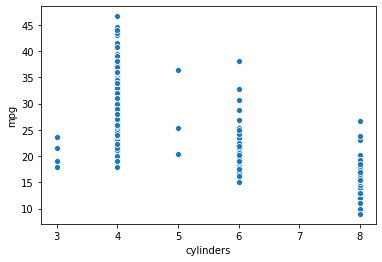

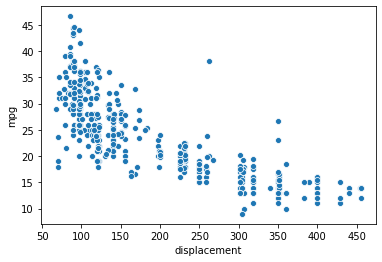

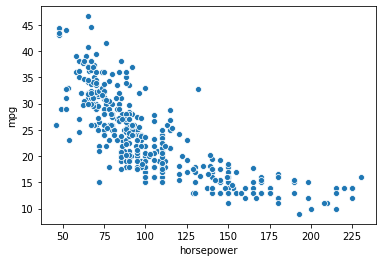

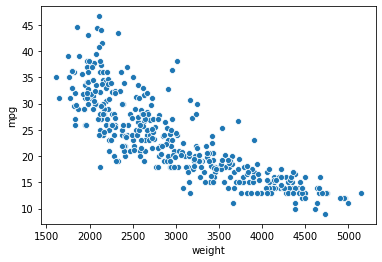

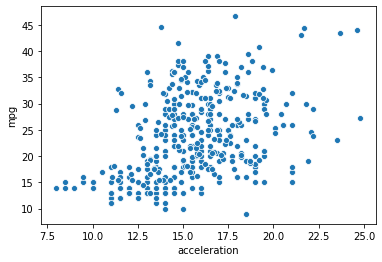

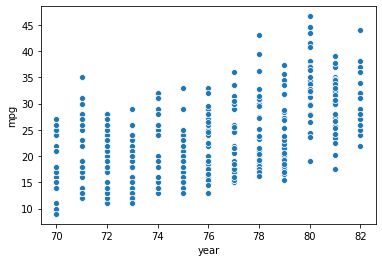

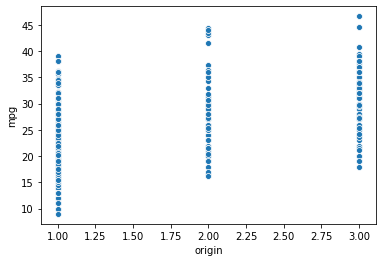

In [7]:
for col in auto.columns:
    if not (col == 'name' or col == 'mpg'):
        sns.scatterplot(x = col, y = 'mpg', data=auto)
        plt.show()

In [8]:
# we will recall this function that we used earlier
def poly_regression_cv(X,y,power):
    scores_dict = {}
    for n in range(1,power+1):
        poly = PolynomialFeatures(n,include_bias=False)
        X_transformed = poly.fit_transform(X.to_frame())
        lin_reg = LinearRegression()
        scores_dict[n] = (-np.mean(cross_val_score(lin_reg,X_transformed,y,scoring = 'neg_mean_squared_error',cv = 5)))
    return scores_dict    

Best degree for cylinders is 3


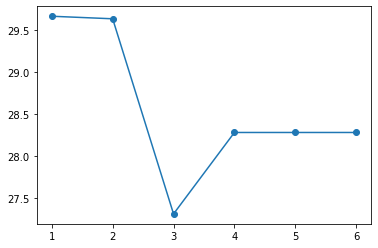

Best degree for displacement is 2


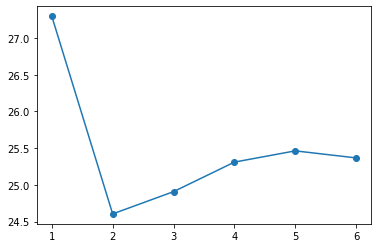

Best degree for horsepower is 6


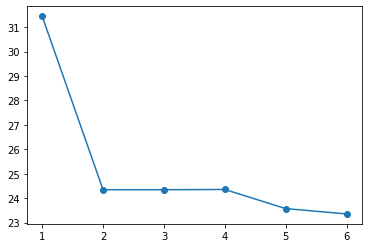

Best degree for weight is 2


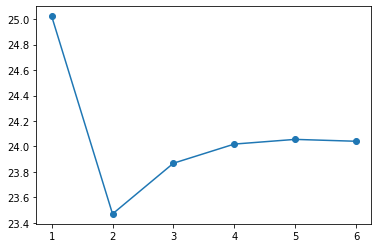

Best degree for acceleration is 4


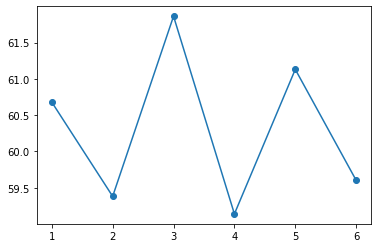

In [10]:
for col in auto.columns:
    if not (col in ['mpg', 'name', 'origin', 'year']):
        scores = poly_regression_cv(auto[col], auto['mpg'], 6)
        print(f"Best degree for {col} is {min(scores, key = lambda k:scores[k])}")
        plt.plot(np.arange(1,7), list(scores.values()), marker = 'o')
        plt.show()

In [11]:
# 9. This question uses the variables dis (the weighted mean of distances to five Boston employment centers) 
# and nox (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat dis as 
# the predictor and nox as the response.

from sklearn.datasets import load_boston
boston_dict = load_boston()
boston_dict.keys()


dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [12]:
boston = pd.DataFrame(boston_dict['data'],columns=boston_dict['feature_names'])
print(boston.shape)
boston.head()

(506, 13)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


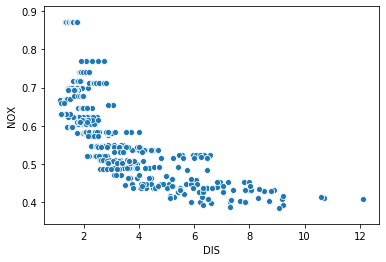

In [13]:
X = boston['DIS']
y = boston['NOX']

sns.scatterplot(X, y)

Mean squared error is: 0.003822345271104882


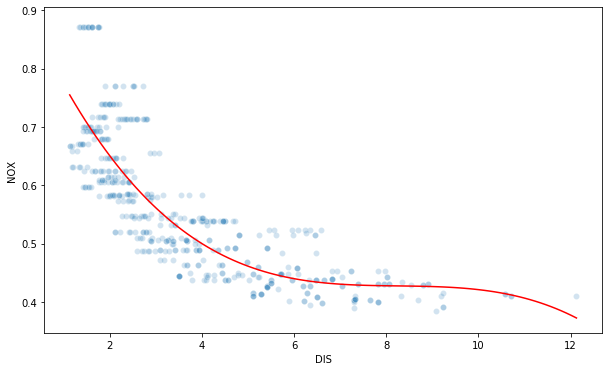

In [16]:
# (a) Use the poly() function to fit a cubic polynomial regression to predict nox using dis. Report the 
# regression output, and plot the resulting data and polynomial fits.

poly = PolynomialFeatures(3, include_bias=False)
X_poly = poly.fit_transform(X.to_frame())

lr = LinearRegression().fit(X_poly, y)

preds = lr.predict(X_poly)
mse = mean_squared_error(y, preds)
print(f'Mean squared error is: {mse}')

X_test = np.linspace(min(X), max(X), 100)
X_test_poly = poly.fit_transform(X_test.reshape(-1, 1))
preds_test = lr.predict(X_test_poly)

plt.figure(figsize = (10, 6))
sns.scatterplot(X, y, alpha = .2)
sns.lineplot(X_test, preds_test, c = 'r')

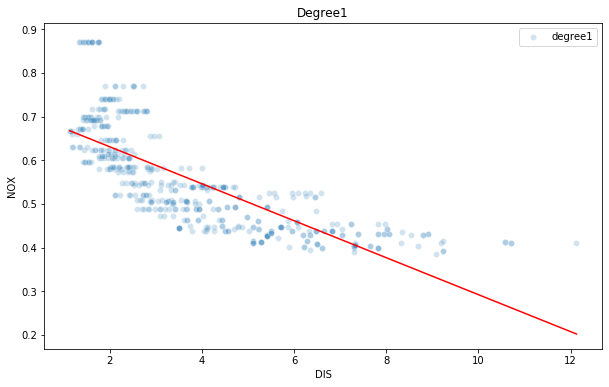

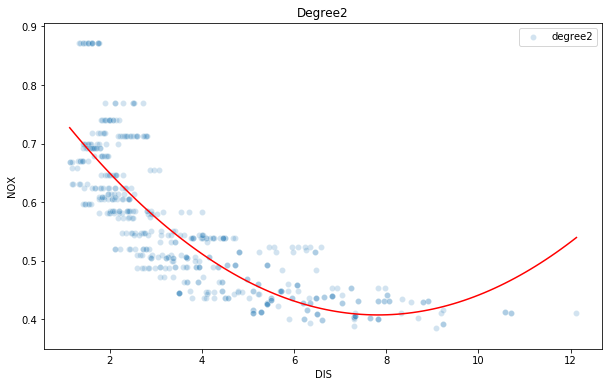

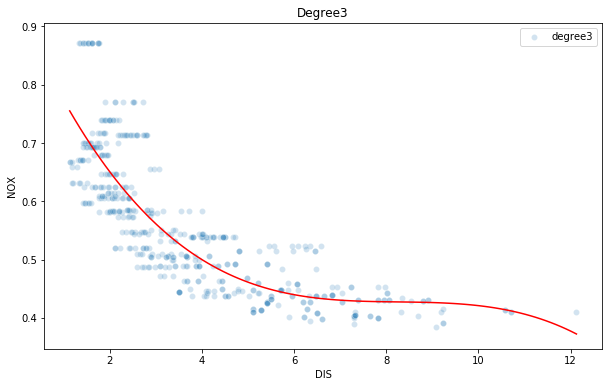

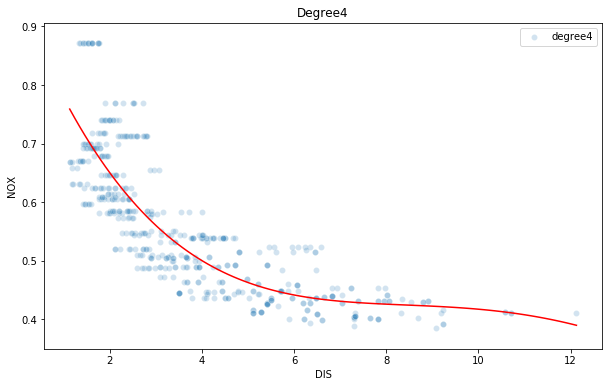

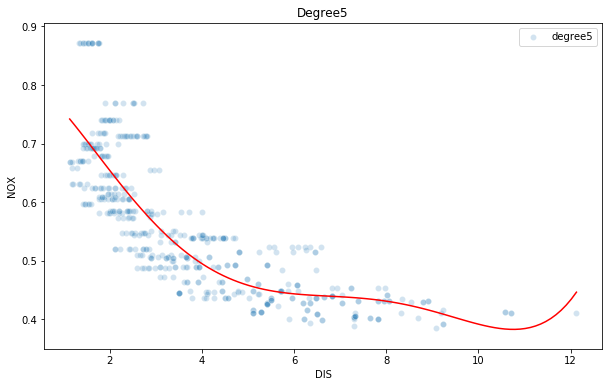

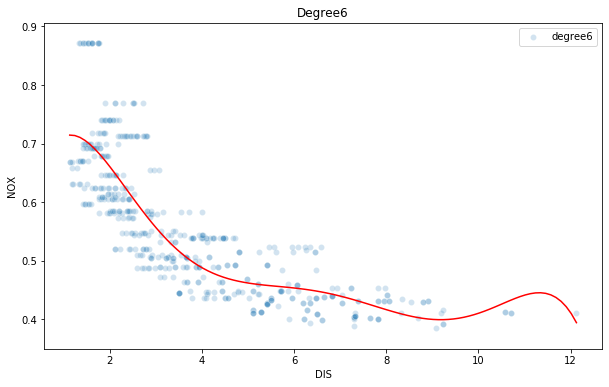

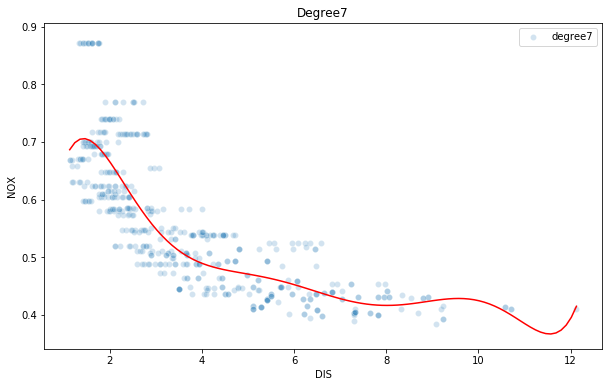

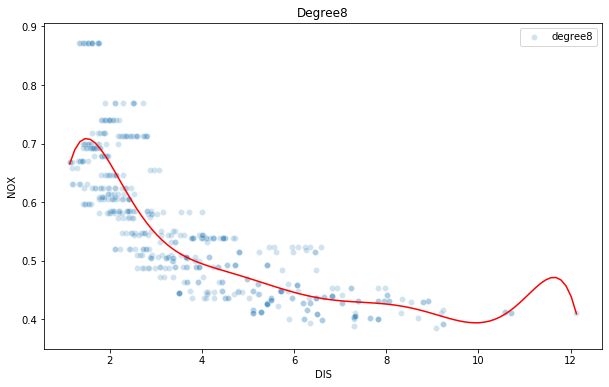

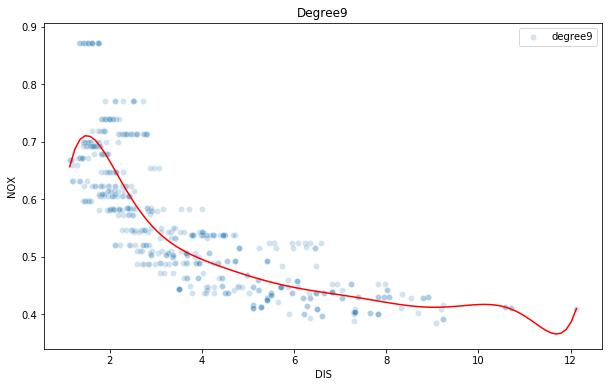

In [17]:
# (b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report 
# the associated residual sum of squares.

rss_dict = {}

for power in range(1, 10):
    poly = PolynomialFeatures(power, include_bias=False)
    X_poly = poly.fit_transform(X.to_frame())
    
    lr = LinearRegression().fit(X_poly, y)
    
    preds = lr.predict(X_poly)
    rss_dict[power] = mean_squared_error(y, preds)
    
    X_test = np.linspace(min(X), max(X), 100)
    X_test_poly = poly.fit_transform(X_test.reshape(-1, 1))
    preds_test = lr.predict(X_test_poly)
    
    plt.figure(figsize = (10, 6))
    sns.scatterplot(X, y, alpha = 0.2, label = 'degree' + str(power))
    sns.lineplot(X_test, preds_test, c = 'r')
    plt.title('Degree' + str(power))

In [18]:
pd.DataFrame(rss_dict,index = ['RSS']).T

,RSS
1,0.005471
2,0.004022
3,0.003822
4,0.003820
5,0.003785
6,0.003712
7,0.003655
8,0.003628
9,0.003623


Text(0, 0.5, 'Training loss')

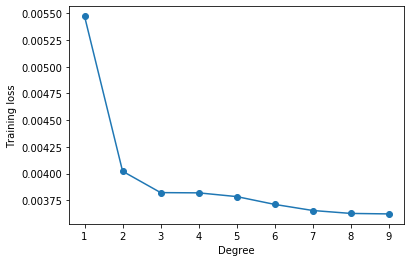

In [19]:
plt.plot(np.arange(1, 10), list(rss_dict.values()), marker = 'o')
plt.xlabel('Degree')
plt.ylabel('Training loss')

In [20]:
# we can see that training rss always deceases with degree

In [21]:
# (c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and 
# explain your results

# we will recall this function that we used earlier
def poly_regression_cv(X,y,power):
    scores_dict = {}
    for n in range(1,power+1):
        poly = PolynomialFeatures(n,include_bias=False)
        X_transformed = poly.fit_transform(X.to_frame())
        lin_reg = LinearRegression()
        scores_dict[n] = (-np.mean(cross_val_score(lin_reg,X_transformed,y,scoring = 'neg_mean_squared_error',cv = 10)))
    return scores_dict    

Text(0, 0.5, '10-CV error')

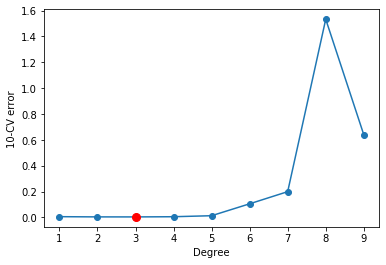

In [23]:
scores_dict = poly_regression_cv(X, y, 9)
plt.plot(np.arange(1, 10), list(scores_dict.values()), marker = 'o')
plt.plot(min(scores_dict, key = lambda k: scores_dict[k]), min(scores_dict.values()), marker = 'o', markersize = 8, color = 'r')
plt.xlabel('Degree')
plt.ylabel('10-CV error')

In [24]:
# (d) Use the bs() function to fit a regression spline to predict nox using dis. Report the output for the f
# it using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

# bs() can produce B-spline bases of arbitrary degrees – e.g., degree=0 will produce piecewise-constant 
# functions, degree=1 will produce piecewise-linear functions, and the default degree=3 produces cubic splines. 
# source - https://patsy.readthedocs.io/en/latest/spline-regression.html#:~:text=bs()%20can%20produce%20B,different%20types%20of%20cubic%20splines.

Text(0.5, 1.0, 'Degree 9')

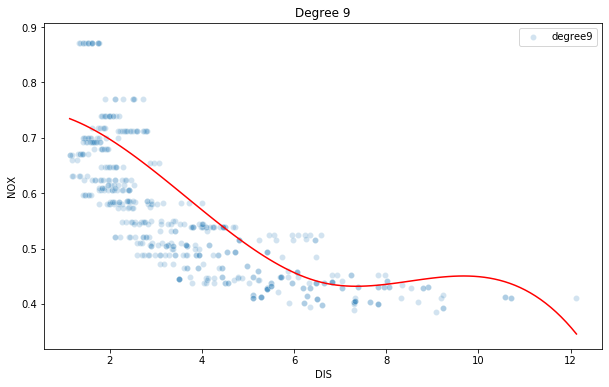

In [25]:
#using bs to get a transfomered metrix which then will be used for fitting a linear model
X_transformed = dmatrix('bs(DIS,df=4)',data = {'DIS':X},return_type = 'dataframe')


lr = LinearRegression()
lr.fit(X_transformed,y)

#choosing some test values for x axis
X_test = np.linspace(min(X),max(X),100)
X_test_transformed =  dmatrix('bs(DIS_test,df=4)',data = {'DIS_test':X_test},return_type = 'dataframe')

#getting the predictions for test data, which wil be used for plotting the predicted spline
preds = lr.predict(X_test_transformed)

plt.figure(figsize = (10,6))
sns.scatterplot(X,y,alpha = 0.2,label = 'degree' + str(power))
sns.lineplot(X_test,preds,c = 'r')
plt.title('Degree ' + str(power))


In [30]:
# in the above graph, the knots were chosen as the four quantiles

def splines(X, y, total_dfs):
    rss_dict = {}
    
    for df in range(3, total_dfs+1):
        # using bs to get a transformed matrix which will then be used for fitting a linear model
        X_transformed = dmatrix('bs(DIS, df = {})'.format(df), data = {'DIS':X}, return_type='dataframe')
        
        lr = LinearRegression().fit(X_transformed, y)
        preds = lr.predict(X_transformed)
        rss = np.round(np.sum((y - preds)**2), 3)
        rss_dict[df] = rss
        
        plt.figure(figsize = (10, 6))
        sns.scatterplot(X, y, alpha = 0.2, label = 'degree' + str(power))
        sns.lineplot(X, preds, c = 'r')
        plt.title('Degrees of Freedom ' + str(df))
        plt.show()
    return rss_dict

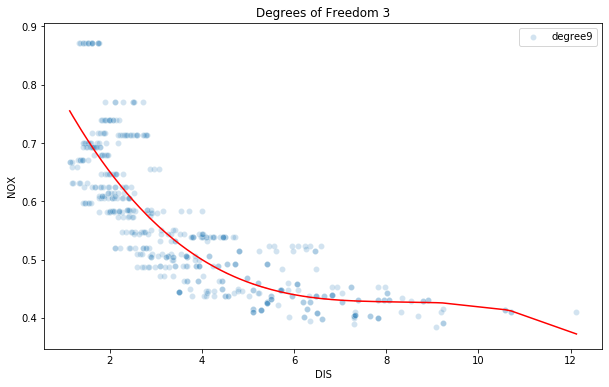

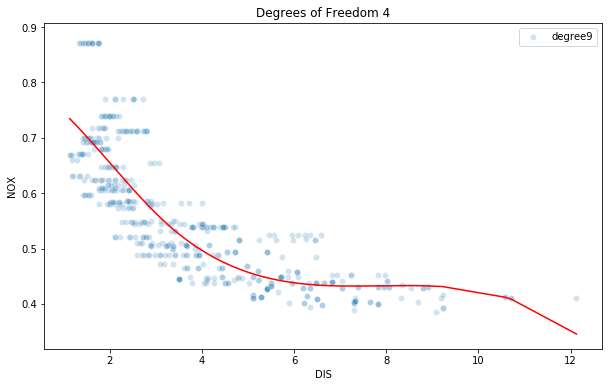

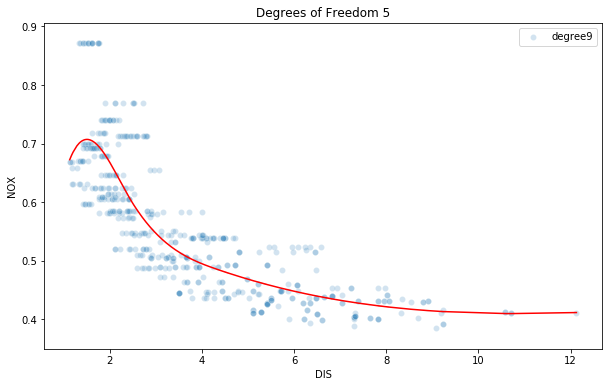

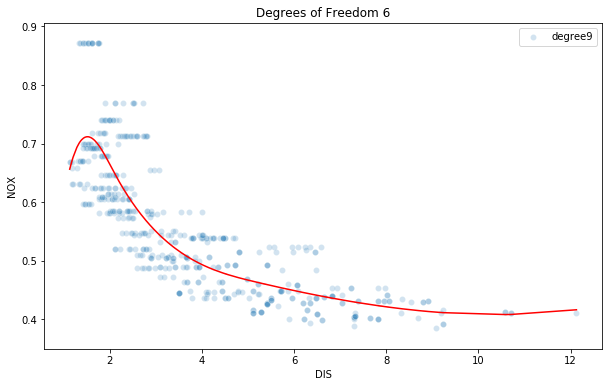

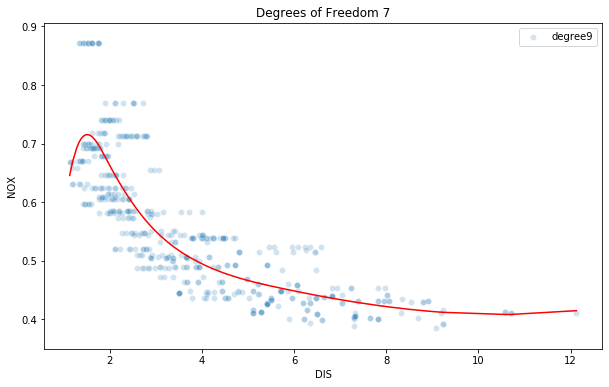

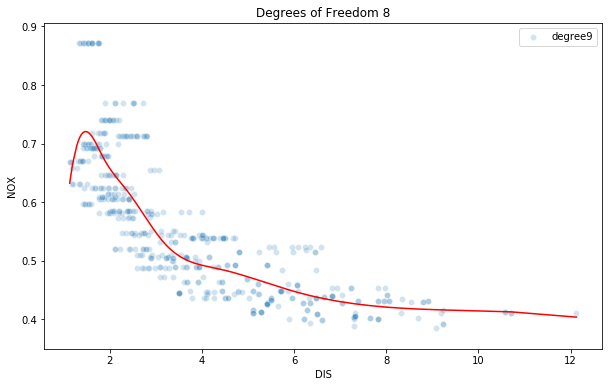

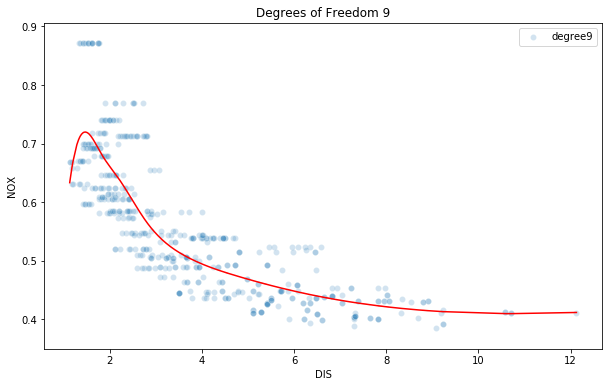

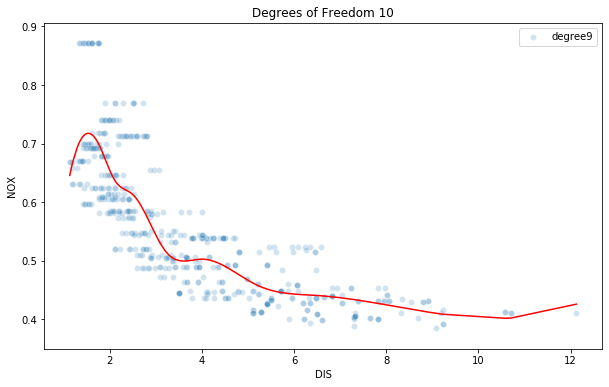

In [31]:
scores_splines = splines(X, y, 10)

Text(0, 0.5, 'RSS')

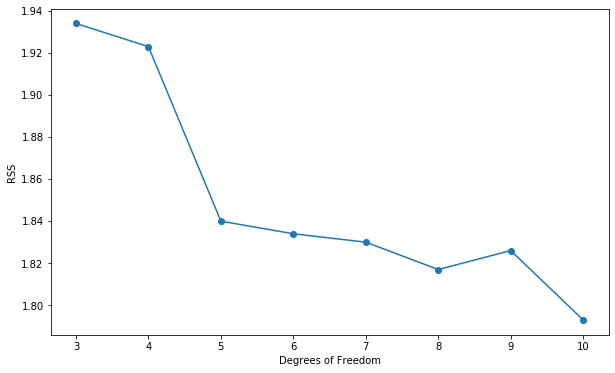

In [32]:
plt.figure(figsize = (10, 6))
plt.plot(np.arange(3, 11), list(scores_splines.values()), marker = 'o')
plt.xlabel('Degrees of Freedom')
plt.ylabel('RSS')

In [33]:
# As expected the RSS decreases with degrees of freedom, hence we cannot decide from training RSS which is the 
# best df.

In [34]:
# (f) Perform cross-validation or another approach in order to select the best degrees of freedom for a 
# regression spline on this data. Describe your results.

def splines_cv(X,y,total_dfs):
    scores_dict = {}
    for df in range(3,total_dfs+1):
        #using bs to get a transfomered metrix which then will be used for fitting a linear model
        X_transformed = dmatrix('bs(DIS,df={})'.format(df),data = {'DIS':X},return_type = 'dataframe')
        lr = LinearRegression()
        scores_dict[df] = (-np.mean(cross_val_score(lr,X_transformed,y,scoring = 'neg_mean_squared_error',cv = 10)))

    return scores_dict    

In [35]:
splines_cv_scores = splines_cv(X,y,10)

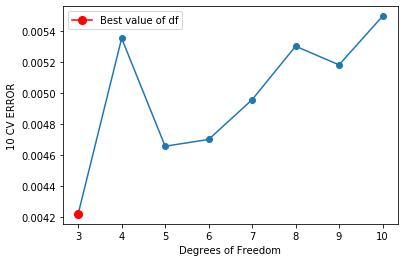

In [36]:
plt.plot(np.arange(3, 11), list(splines_cv_scores.values()), marker = 'o')
plt.plot(min(splines_cv_scores, key = lambda k: splines_cv_scores[k]), min(list(splines_cv_scores.values())),marker = 'o',markersize = 8,color = 'r',label = 'Best value of df')
plt.xlabel('Degrees of Freedom')
plt.ylabel('10 CV ERROR')
plt.legend()

In [37]:
# the best value of df is 3

In [38]:
## 10. This question relates to the College data set.

In [37]:
college = pd.read_csv('/home/abhishek/Desktop/ISLR-Applied-Exercises-in-Python/data/College.csv')
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [38]:
college = college.iloc[:, 1:]

In [39]:

print(college.shape)
college.head()

(777, 18)


,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [40]:
college['Private'] = college['Private'].map({'Yes': 1, 'No': 0})
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [41]:
# later down in the notebook, i was having trouble with names of the cols. 
# Sonce it has . in between the col names, that was creating error in dmatrix(), hence i replace it with underscore
college.columns = ['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S_F_Ratio', 'perc_alumni', 'Expend',
       'Grad_Rate']
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F_Undergrad,P_Undergrad,Outstate,Room_Board,Books,Personal,PhD,Terminal,S_F_Ratio,perc_alumni,Expend,Grad_Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [42]:
# a) Split the data into a training set and a test set. Using out-of-state tuition as the response and the 
# other variables as the predictors, perform forward stepwise selection on the training set in order to 
# identify a satisfactory model that uses just a subset of the predictors.


def forward_stepwise_selection(data,target):
    total_features = [[]]
    score_dict = {}
    remaining_features = [col for col in data.columns if not col == target]
    for i in range(1,len(data.columns)):
        best_score = 0;best_feature = None
        for feature in remaining_features:

            X = total_features[i-1] + [feature]
            model = LinearRegression().fit(data[X],data[target])
            score = r2_score(data[target],model.predict(data[X]))
#             print('For len {}, feature - {}, score is {}'.format(i,feature,score))

            if score > best_score:
                best_score = score
                best_feature = feature
        total_features.append(total_features[i-1] + [best_feature])
        remaining_features.remove(best_feature)
        score_dict[i] = best_score
    return total_features,score_dict

In [43]:
total_features_fwd, score_dict_fwd = forward_stepwise_selection(college, 'Outstate')

In [44]:
# lets print the selceted features for first 5 models
for i in range(1,len(total_features_fwd)-1):
    print('The best model with {} features - {}'.format(i,total_features_fwd[i]))
    print('R_2 score is ',score_dict_fwd[i])
    print()

The best model with 1 features - ['Expend']
R_2 score is  0.4526310701309323

The best model with 2 features - ['Expend', 'Private']
R_2 score is  0.6063620641055406

The best model with 3 features - ['Expend', 'Private', 'Room_Board']
R_2 score is  0.6826021264742166

The best model with 4 features - ['Expend', 'Private', 'Room_Board', 'perc_alumni']
R_2 score is  0.7192093330167272

The best model with 5 features - ['Expend', 'Private', 'Room_Board', 'perc_alumni', 'PhD']
R_2 score is  0.7370261185735234

The best model with 6 features - ['Expend', 'Private', 'Room_Board', 'perc_alumni', 'PhD', 'Grad_Rate']
R_2 score is  0.7473191507945701

The best model with 7 features - ['Expend', 'Private', 'Room_Board', 'perc_alumni', 'PhD', 'Grad_Rate', 'Personal']
R_2 score is  0.7498676903366897

The best model with 8 features - ['Expend', 'Private', 'Room_Board', 'perc_alumni', 'PhD', 'Grad_Rate', 'Personal', 'Terminal']
R_2 score is  0.7520143518621463

The best model with 9 features - ['Ex

Text(0.5, 1, 'Forward selection')

<Figure size 720x432 with 0 Axes>

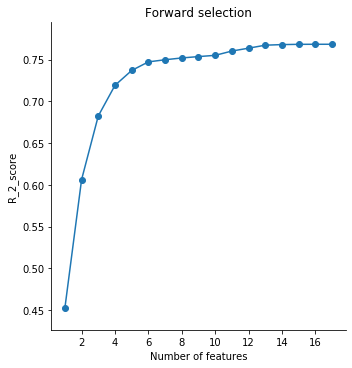

In [45]:
temp = pd.DataFrame({'Number of features': np.arange(1, len(total_features_fwd)), 'R_2_score': list(score_dict_fwd.values())})
plt.figure(figsize = (10, 6))
g = sns.FacetGrid(data = temp, size = 5)
g.map(plt.scatter, 'Number of features', 'R_2_score')
g.map(plt.plot, 'Number of features', 'R_2_score')
plt.xticks = list(np.arange(1, len(total_features_fwd)))
plt.title('Forward selection')

In [46]:
# we can't take this graph to decide no. of features, for that we could use train and test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(college.drop('Outstate', axis = 1), college['Outstate'], test_size = 0.4, random_state = 1)


In [48]:
validation_scores_dict = {}
for features in total_features_fwd[1:]:
    lr = LinearRegression().fit(X_train[features], y_train)
    preds = lr.predict(X_test[features])
    validation_scores_dict[len(features)] = mean_squared_error(y_test, preds)

Text(0, 0.5, 'Validation error')

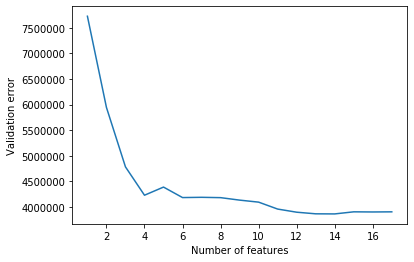

In [49]:
plt.plot(list(validation_scores_dict.keys()),list(validation_scores_dict.values()))
plt.xlabel('Number of features')
plt.ylabel('Validation error')

In [50]:
# best model is that with 13 features

In [51]:
features_selected = total_features_fwd[13]

In [52]:
# (b) Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in 
# the previous step as the predictors. Plot the results, and explain your findings.

def find_best_degree(X,y,power):
    scores_dict = {}
    for n in range(3,power+1):
        poly = PolynomialFeatures(n,include_bias=False)
        X_transformed = poly.fit_transform(X.to_frame())
        lin_reg = LinearRegression()
        scores_dict[n] = (-np.mean(cross_val_score(lin_reg,X_transformed,y,scoring = 'neg_mean_squared_error',cv = 5)))
    return min(scores_dict, key=lambda k: scores_dict[k])

Best degree for Expend is 3 


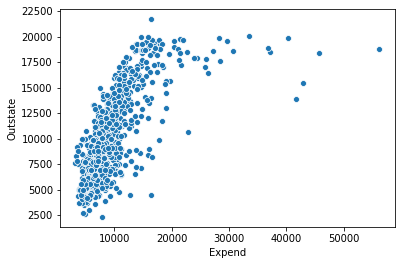

Best degree for Private is 3 


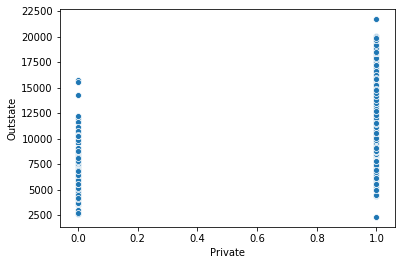

Best degree for Room_Board is 3 


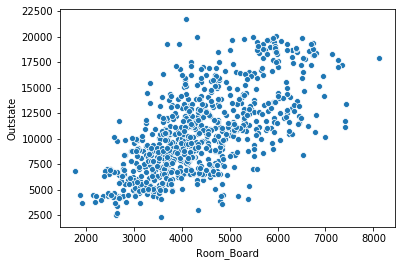

Best degree for perc_alumni is 3 


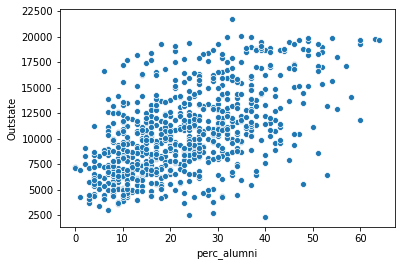

Best degree for PhD is 3 


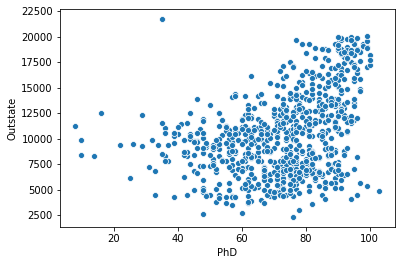

Best degree for Grad_Rate is 3 


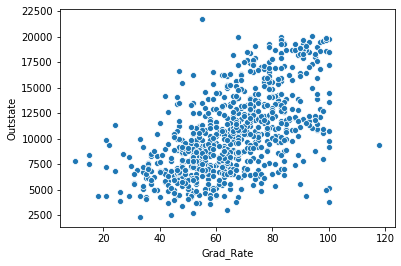

Best degree for Personal is 3 


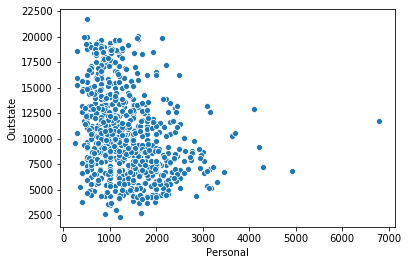

Best degree for Terminal is 3 


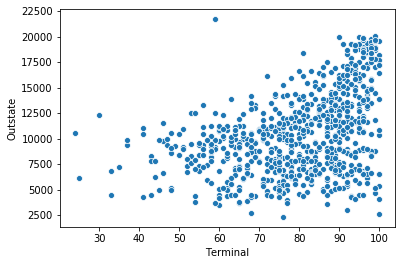

Best degree for S_F_Ratio is 4 


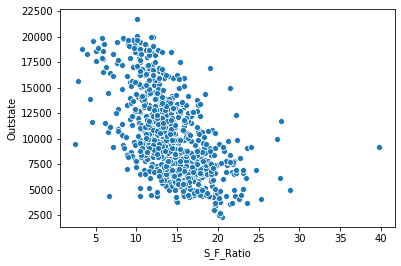

Best degree for Accept is 3 


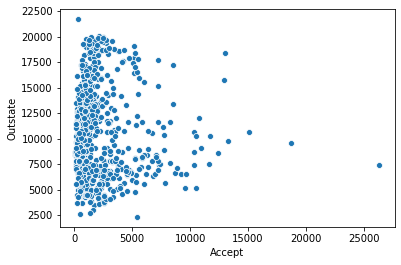

Best degree for F_Undergrad is 4 


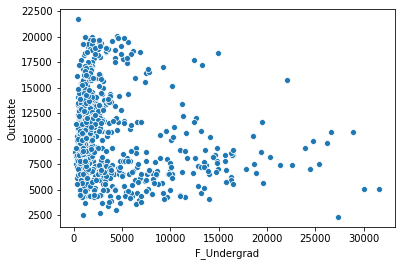

Best degree for Apps is 3 


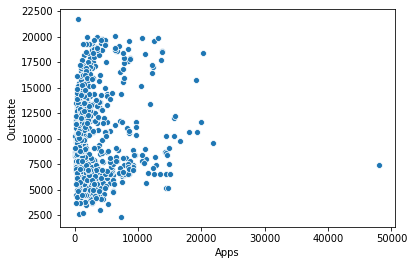

Best degree for Top10perc is 3 


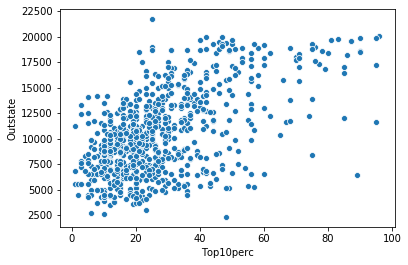

In [53]:
best_degree_list = []
for feature in features_selected:
    best_degree = find_best_degree(college[feature], college['Outstate'], 6)
    print(f'Best degree for {feature} is {best_degree} ')
    best_degree_list.append(best_degree)
    sns.scatterplot(college[feature], college['Outstate'])
    plt.show()

In [54]:
formula = ' + '.join(['cr({},df = {})'.format(feature,d) for (feature,d) in zip(features_selected,best_degree_list)])

In [55]:
X_transformed = dmatrix(formula,data = X_train,return_type = 'dataframe')

model = sm.OLS(y_train,X_transformed).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Outstate   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     65.95
Date:                Thu, 19 Nov 2020   Prob (F-statistic):          4.85e-136
Time:                        10:39:08   Log-Likelihood:                -4158.7
No. Observations:                 466   AIC:                             8373.
Df Residuals:                     438   BIC:                             8489.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [57]:
# (c) Evaluate the model obtained on the test set, and explain the results obtained.

X_transformed_test = dmatrix(formula,data = X_test,return_type = 'dataframe')

test_preds = model.predict(X_transformed_test)
print('R2 score for test is ',r2_score(y_test,test_preds))

R2 score for test is  0.7765408231836259


In [59]:
### (d) For which variables, if any, is there evidence of a non-linear relationship with the response?

list(zip(features_selected,best_degree_list))

[('Expend', 3),
 ('Private', 3),
 ('Room_Board', 3),
 ('perc_alumni', 3),
 ('PhD', 3),
 ('Grad_Rate', 3),
 ('Personal', 3),
 ('Terminal', 3),
 ('S_F_Ratio', 4),
 ('Accept', 3),
 ('F_Undergrad', 4),
 ('Apps', 3),
 ('Top10perc', 3)]